### In-Class Two-Layer Base

In [3]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [4]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        
        # for each instance's activations 
        for (a1,a2,a3,y) in zip(A1.T,A2.T,A3.T,Y_enc.T):
            dJ_dz2 = -2*(y - a3)*a3*(1-a3)
            dJ_dz1 = dJ_dz2 @ W2 @ np.diag(a2*(1-a2))
                         
            grad2 += dJ_dz2[:,np.newaxis]  @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

In [5]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

### Custom MLP Implementation


> TO DO
* Multilayer gradient
* Weight initialization
* Update fit function for new gradients

In [183]:
class MultilayerPerceptron(TwoLayerPerceptronVectorized):
    def __init__(self, nlayers=3, phi='sigmoid', cost='quadratic', **kwds):
        
        self.nlayers = nlayers
        self.phi_func = phi
        self.cost_func = cost
        
        super().__init__(**kwds)
        
        
    @staticmethod
    def _L2_reg(lambda_, weights):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        sum_ = 0
        for w in weights:
            sum_ += np.mean(w[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(sum_)
    
    @staticmethod
    def _linear(x):
        return x
    
    def _initialize_weights(self):
        
        _weights = []
        for i in range(self.nlayers-1):
            """Initialize weights with small random numbers."""
            if i == 0:              
                W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
                W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
                W1[:,:1] = 0 # common practice to start with zero bias
                _weights.append(W1)
                continue
            W1 = np.random.randn(self.n_hidden, _weights[i-1].shape[1] + 1)
            W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
            W1[:,:1] = 0 # common practice to start with zero bias
            _weights.append(W1)
            
    
        '''initialize weights for output layer'''
        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(_weights[i-1].shape[1]+1) # don't saturate the neuron
        W2[:,:1] = 0 # common practice to start with zero bias
        _weights.append(W2)
        
        return _weights

        
    def _feedforward(self, X, weights):
        
        _layers = [] # list of A matrices
        
        '''set phi function'''
        if self.phi_func == 'sigmoid':
            _phi = self._sigmoid
        elif seld.phi_func == 'linear':
            _phi = self._linear
            
        
        for i in range(self.nlayers+1):
            #compute first layer
            if i == 0:
                A1 = self._add_bias_unit(X.T, how='row')
                _layers.append(A1)
                print("A{} shape:{}".format(i+1, A1.shape))
                continue
                
            #compute ith layer
            A_prev = _layers[i-1]
            W_prev = weights[i-1]
            
            print("W{} shape:{}".format(i+1, W_prev.shape))
            Z_prev = W_prev @ A_prev
            print("Z{} shape:{}".format(i+1, Z_prev.shape))
            A_i = _phi(Z_prev)
            print("A{} shape:{}".format(i+1, A_i.shape))
            
            #add bias, if layer isn't output layer
            if i < self.nlayers:
                A_i = self._add_bias_unit(A_i, how='row')

            #add layer to _layers
            _layers.append(A_i)
            
            
        return _layers
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]                
        self.weights = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            layers = self._feedforward(X_data, self.weights)

            cost = self._cost(layers[self.nlayers],Y_enc, self.weights)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grads = self._get_gradient(layers=layers, Y_enc=Y_enc, weights=self.weights)

            #update weights
            for i in range(len(self.weights)):
                self.weights[i] -= self.eta * grads[i]
            

        return self
    
    def predict(self, X):
        """Predict class labels"""
        layers= self._feedforward(X, self.weights)
        y_pred = np.argmax(layers[self.nlayers], axis=0)
        return y_pred
    
    def _cost(self, Af, Y_enc, weights):
        '''Get the objective function value'''
        
        if self.cost_func == 'quadratic':            
            cost = np.mean((Y_enc-Af)**2)
            L2_term = self._L2_reg(self.l2_C, weights)
            
        elif self.cost_func == 'cross_entropy':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(Af)+(1-Y_enc)*np.log(1-Af))))
            L2_term = self._L2_reg(self.l2_C, weights)
            
        return cost + L2_term

    
    def _get_gradient(self, layers, Y_enc, weights):
        """ Compute gradient step using backpropagation for each layer
        """
        _V = []
        _grads = []
        
        '''calculate sensitivity at final layer'''
        #quadratic cost
        if self.cost_func == 'quadratic':
            Vf = -2 * (Y_enc-layers[self.nlayers])*layers[self.nlayers]*(1-layers[self.nlayers])
            
        #cross entropy cost   
        elif self.cost_func == 'cross_entropy':
            Vf = (layers[self.nlayers] - Y_enc) 
            
        '''calculate gradient for wrt last layer'''
        grad_f = Vf @ layers[self.nlayers-1].T

        #regularize gradient that are not bias
        grad_f[:,1:] += weights[self.nlayers-1][:, 1:] * self.l2_C
        
        _V.append(Vf)
        _grads.append(grad_f)
        
        '''backpropagate through L-1 layers to calculate sensitivities''' 
        for i in range(self.nlayers-2,-1,-1):
            
            A_i = layers[i+1]  #A_i+1
            W_i = weights[i+1] #W_i+1
            V_i2 = _V[0]       #uses sensitivity of layer (i+1)
            
            #calculate sensitivity for layer i
            V_i = A_i*(1-A_i)*(W_i.T @ V_i2)
            
            #insert sensitivity for layer i at front of list
            _V.insert(0,V_i)
            
            #calculate gradient for layer i
            grad_i = V_i[1:, :] @ layers[i].T
            
            #regularize weights that are not bias terms
            grad_i[:, 1:] += weights[i][:, 1:]
            
            _grads.insert(0,grad_i)
        
        return _grads
    

### Testing 


In [7]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

ds = load_digits()
X = ds.data/16.0-0.5
y = ds.target

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]


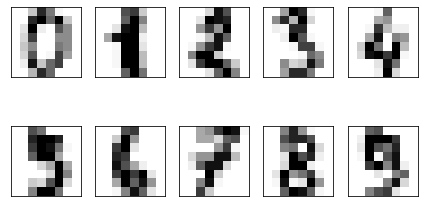

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [9]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1437, 64)
(1437,)
(360, 64)
(360,)


In [184]:

params = dict(n_hidden=30, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              nlayers=3,
              phi='sigmoid',
              cost='quadratic',
              )


mlp = MultilayerPerceptron(**params)


In [185]:
mlp.fit(X_train, y_train, print_progress=True)
yhat = mlp.predict(X_test)
print("Accuracy:",accuracy_score(y_test,yhat))

Epoch: 1/200

A1 shape:(65, 1437)
W2 shape:(30, 65)
Z2 shape:(30, 1437)
A2 shape:(30, 1437)
W3 shape:(30, 66)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 66)

In [135]:
mlp.weights[1].shape

(10, 31)

In [117]:
X_train.shape

(1437, 64)